In [1]:
### I have been using features from layer1, layer2, layer3, layer4, final layer
### Let's try with the individual conv layers e.g. layer2.0.conv1
### Cadena et al. use sublayers for VGG-19 https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006897#sec002

In [2]:
import numpy as np
from os import path
import matplotlib.pyplot as plt

### 1.1. Load data

# imresps.npy is of shape (1573, 2, 15363), where 1573 is number of images, 2 repeats each, and 15363 neurons recorded
# stimids.npy has the image id (matching the image dataset ~selection1866~) for each stimulus number, 
# so of you want to see what image was presented on imresps[502] you would check stim_ids[502]

PATH_TO_DATA = '../../data/neural'

imresps = np.load(path.join(PATH_TO_DATA, 'imresps.npy'))
stimids = np.load(path.join(PATH_TO_DATA, 'stimids.npy'))

print(imresps.shape) # (1573, 2, 15363)
print(stimids.shape) # (1573,)

(1573, 2, 15363)
(1573,)


[ 0.02218052 -0.02226785  0.01590024 ...  0.00192296 -0.0053701
  0.03536492]
[-0.01181713  0.03066771 -0.02080986 ...  0.01532763 -0.02976947
  0.0410882 ]


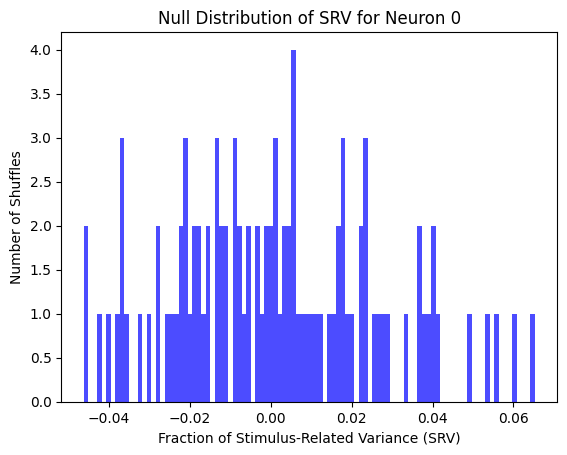

[-0.02870272 -0.00786691 -0.03683036 ...  0.20554758  0.03229079
  0.02278727]
[-0.02790186 -0.0078055  -0.03552207 ...  0.25872862  0.03336828
  0.02331864]
Real SRV shape: (15363,)


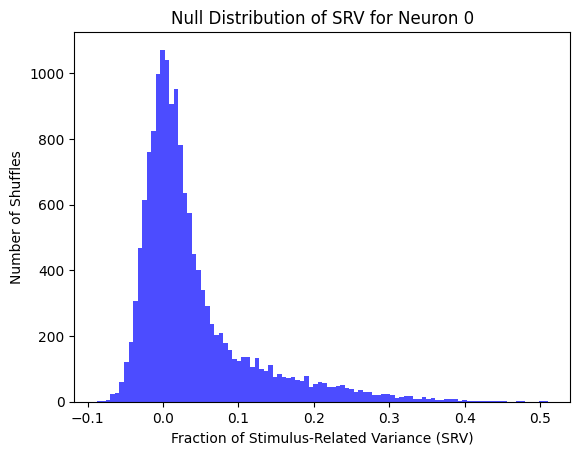

[0.06007116 0.05986482 0.0643733  ... 0.06378336 0.04984847 0.07329934]
Number of reliable neurons: 3703
Indices of reliable neurons: [   14    70    92 ... 15357 15358 15360]


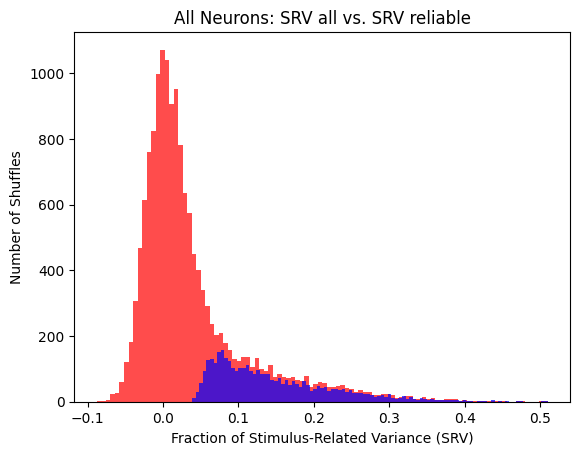

In [3]:
### 2.1. Compute the null distribution of SRV values for all neurons

def compute_signal_related_variance(resp_a, resp_b, mean_center=True):
    """
    compute the fraction of signal-related variance for each neuron,
    as per Stringer et al Nature 2019. Cross-validated by splitting
    responses into two halves. Note, this only is "correct" if resp_a
    and resp_b are *not* averages of many trials.

    Args:
        resp_a (ndarray): n_stimuli, n_cells
        resp_b (ndarray): n_stimuli, n_cells

    Returns:
        fraction_of_stimulus_variance: 0-1, 0 is non-stimulus-caring, 1 is only-stimulus-caring neurons
        stim_to_noise_ratio: ratio of the stim-related variance to all other variance
    """
    if len(resp_a.shape) > 2:
        # if the stimulus is multi-dimensional, flatten across all stimuli
        resp_a = resp_a.reshape(-1, resp_a.shape[-1])
        resp_b = resp_b.reshape(-1, resp_b.shape[-1])
    ns, nc = resp_a.shape
    if mean_center:
        # mean-center the activity of each cell
        resp_a = resp_a - resp_a.mean(axis=0)
        resp_b = resp_b - resp_b.mean(axis=0)
    
    # compute the cross-trial stimulus covariance of each cell
    # dot-product each cell's (n_stim, ) vector from one half
    # with its own (n_stim, ) vector on the other half

    covariance = (resp_a * resp_b).sum(axis=0) / ns

    # compute the variance of each cell across both halves
    resp_a_variance = (resp_a**2).sum(axis=0) / ns
    resp_b_variance = (resp_b**2).sum(axis=0) / ns
    total_variance = (resp_a_variance + resp_b_variance) / 2

    if np.any(total_variance < 1e-12):
        print(f"Warning: Near-zero total variance for neurons: {np.where(total_variance < 1e-12)[0]}")

    # compute the fraction of the total variance that is
    # captured in the covariance
    fraction_of_stimulus_variance = covariance / total_variance

    # if you want, you can compute SNR as well:
    stim_to_noise_ratio = fraction_of_stimulus_variance / (
        1 - fraction_of_stimulus_variance
    )

    return fraction_of_stimulus_variance, stim_to_noise_ratio

# TODO: double check INDEXING (images, cells)

# imresps shape = (1573, 2, 15363)
# responses in imresps shape = (2, 15363)
num_stimuli = imresps.shape[0] # 1573
num_repeats = imresps.shape[1] # 2
num_neurons = imresps.shape[2] # 15363
n_shuffles = 100

null_srv_all_neurons = [] # shape (n_shuffles, num_neurons)

for _ in range(n_shuffles):
    # Shuffle stimulus indices *twice* to create two independent splits!
    shuffled_indices_A = np.random.permutation(num_stimuli)
    shuffled_indices_B = np.random.permutation(num_stimuli)

    # Now for the splits, we can just use fixed repeat indices, 
    # because for each split, at index N the responses correspond to different stimuli
    # e.g. split_A = [ stim_100_repeat_1, stim_2_repeat_1, stim_19_repeat_1, ... ]
    # e.g. split_B = [ stim_543_repeat_2, stim_345_repeat_2, stim_3_repeat_2, ... ]
    split_A = imresps[shuffled_indices_A, 0, :]
    split_B = imresps[shuffled_indices_B, 1, :]

    # Compute SRV for the shuffled data
    fraction_of_stimulus_variance, _ = compute_signal_related_variance(split_A, split_B)
    null_srv_all_neurons.append(fraction_of_stimulus_variance)

null_srv_all_neurons = np.array(null_srv_all_neurons)
null_srv_all_neurons.shape # (100, 15363)

print(null_srv_all_neurons[0])
print(null_srv_all_neurons[33])

# e.g. if neuron_index = 0, it will plot the SRV value for neuron 0 across all shuffles
neuron_index = 0
plt.hist([srv[neuron_index] for srv in null_srv_all_neurons], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

### 2.2. Compute the real SRV for each neuron

# TODO: Question for Ali: why can't we just split like this?
# split_A_real = imresps[:, 0, :] # First repeat for each stimulus
# split_B_real = imresps[:, 1, :] # Second repeat for each stimulus

split_A, split_B = [], []
for responses in imresps: # responses shape: (2, n_neurons)
    indices = np.random.permutation(2) # Randomly shuffle [0, 1]
    split_A.append(responses[indices[0]]) # Assign one repeat to split_A
    split_B.append(responses[indices[1]]) # Assign the other to split_B

split_A = np.array(split_A)  # Shape: (n_stimuli, n_neurons)
split_B = np.array(split_B)  # Shape: (n_stimuli, n_neurons)

# Compute SRV for real data
real_srv_all_neurons, stim_to_noise_ratio = compute_signal_related_variance(split_A, split_B)

print(real_srv_all_neurons)
print(stim_to_noise_ratio)

print("Real SRV shape:", real_srv_all_neurons.shape) # Should be (15363,)

plt.hist(real_srv_all_neurons, bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title(f"Null Distribution of SRV for Neuron {neuron_index}")
plt.show()

### 2.3. Filter neurons whose real SRV is in the top 90th percentile of its null distribution

# This gives the 90th-percentile SRV value of the null distribution for each neuron
# In other words the threshold for each neuron to be considered reliable
# e.g. if neuron 0 has a null distribution of SRVs across 10 shuffles 
# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], the threshold would be 0.9
top_99th_percentile_null = np.percentile(null_srv_all_neurons, 99, axis=0)
print(top_99th_percentile_null) # [0.03651716 0.03126347 0.03325775 ... 0.02738261 0.03546677 0.0333109 ]

# Get indices of reliable neurons
reliable_neuron_indices = np.where(real_srv_all_neurons >= top_99th_percentile_null)[0]

# Print results
print(f"Number of reliable neurons: {len(reliable_neuron_indices)}") # 5654
print(f"Indices of reliable neurons: {reliable_neuron_indices}") # [   14    29    48 ... 15357 15358 15360]

plt.hist(real_srv_all_neurons, bins=100, color='red', alpha=0.7)
plt.hist(real_srv_all_neurons[reliable_neuron_indices], bins=100, color='blue', alpha=0.7)
plt.xlabel("Fraction of Stimulus-Related Variance (SRV)")
plt.ylabel("Number of Shuffles")
plt.title("All Neurons: SRV all vs. SRV reliable")
plt.show()

[   1    2    3 ... 1858 1859 1860]
[1.000e+00 2.000e+00 3.000e+00 ... 1.858e+03 1.859e+03 1.860e+03]
List: ['img1.mat', 'img10.mat', 'img100.mat', 'img1000.mat', 'img1001.mat', 'img1002.mat', 'img1003.mat', 'img1004.mat', 'img1005.mat', 'img1006.mat', 'img1007.mat', 'img1008.mat', 'img1009.mat', 'img101.mat', 'img1010.mat', 'img1011.mat', 'img1012.mat', 'img1013.mat', 'img1014.mat', 'img1015.mat', 'img1016.mat', 'img1017.mat', 'img1018.mat', 'img1019.mat', 'img102.mat', 'img1020.mat', 'img1021.mat', 'img1022.mat', 'img1023.mat', 'img1024.mat', 'img1025.mat', 'img1026.mat', 'img1027.mat', 'img1028.mat', 'img1029.mat', 'img103.mat', 'img1030.mat', 'img1031.mat', 'img1032.mat', 'img1033.mat', 'img1034.mat', 'img1035.mat', 'img1036.mat', 'img1037.mat', 'img1038.mat', 'img1039.mat', 'img104.mat', 'img1040.mat', 'img1041.mat', 'img1042.mat', 'img1043.mat', 'img1044.mat', 'img1045.mat', 'img1046.mat', 'img1047.mat', 'img1048.mat', 'img1049.mat', 'img105.mat', 'img1050.mat', 'img1051.mat', 'i

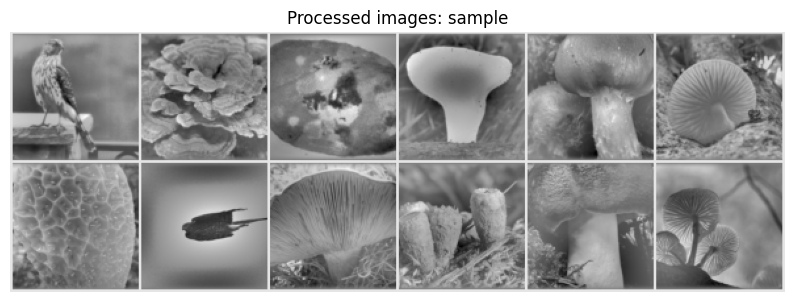

In [4]:
### 3.1. Load and preprocess images

import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Normalize, Compose, Resize, CenterCrop
import torch
from torch.utils.data import TensorDataset
from torchvision import utils as torch_utils
 
PATH_TO_DATA = '../../data/selection1866'

file_list = sorted(f for f in os.listdir(PATH_TO_DATA) if f.endswith('.mat'))
stim_ids = stimids.astype(int)

print(stim_ids)
print(stimids)

# TODO: run tile 1 and 2 through model separately + concat feature reps (no crop, pad)
transform = Compose([
    Resize(96), # Resize shortest edge to 96 (cut off the rightmost part of the image)
    CenterCrop((96, 96)), # Crop to (96, 96)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # !! Normalize expects input is already in the range [0, 1]
])

img_tensors, labels = [], []

print('List:', file_list)

# we have 1866 images here, but the neural response data only uses 1573 of them
# because some ~300 images didn't have two repeats, so were disposed
# therefore we filter the full set here so that we only use the relevant 1573
for stim_id in stim_ids:
    filename = 'img' + str(stim_id) + '.mat'
    data = loadmat(os.path.join(PATH_TO_DATA, filename))

    img = data['img'][:, :500] # Take leftmost part of the image
    rgb_img = np.stack([img] * 3, axis=-1) # Convert grayscale to RGB for SimCLR
    tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
    
    # Min-max scale the tensor to [0, 1]
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    tensor = (tensor - tensor_min) / (tensor_max - tensor_min)

    # Clamp to [0, 1] to ensure no outliers due to numerical precision
    tensor = torch.clamp(tensor, 0.0, 1.0)

    transformed_tensor = transform(tensor) # Normalize and resize for SimCLR
    img_tensors.append(transformed_tensor)
    labels.append(stim_id)

image_dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

images, labels = image_dataset.tensors
print("Labels:", labels[:10])
print("Processed dataset shape:", images.shape) # (N, C, 96, 96)
print(f"Min pixel value (processed): {torch.min(images)}")
print(f"Max pixel value (processed): {torch.max(images)}")

# Show a sample of processed images
img_grid = torch_utils.make_grid(images[:12], nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.title('Processed images: sample')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [8]:
### 3.2. Run images through a pretrained SimCLR model and extract features

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from tqdm.notebook import tqdm
from typing import Dict
from torch.utils.data import Dataset
import urllib.request
from urllib.error import HTTPError

class SimCLR(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        # Base ResNet18 backbone (pretrained=False, because we load custom weights later, from the SimCLR checkpoint file)
        self.convnet = torchvision.models.resnet18(pretrained=False)
        
        # This is the projection head, only needed during training. For downstream tasks it is disposed of
        # and the final linear layer output is used (Chen et al., 2020) 
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        self.intermediate_layers_to_capture =[]
        self.intermediate_layer_features = {}
        self.num_workers = os.cpu_count()
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    def load_pretrained(self):
        """
        Load pretrained SimCLR weights
        """
        base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
        models_dir = "../../models"
        pretrained_simclr_filename = "SimCLR.ckpt"
        pretrained_simclr_path = os.path.join(models_dir, pretrained_simclr_filename)
        os.makedirs(models_dir, exist_ok=True)

        # Check whether the pretrained model file already exists locally. If not, try downloading it
        file_url = base_url + pretrained_simclr_filename
        if not os.path.isfile(pretrained_simclr_path):
            print(f"Downloading pretrained SimCLR model {file_url}...")
            try:
                urllib.request.urlretrieve(file_url, pretrained_simclr_path)
            except HTTPError as e:
                print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

        print(f"Already downloaded pretrained model: {file_url}")

        # Load pretrained model
        checkpoint = torch.load(pretrained_simclr_path, map_location=self.device)
        self.load_state_dict(checkpoint['state_dict'])
        self.to(self.device)
        self.eval()

    def set_intermediate_sublayers_to_capture(self):
        """
        Capture features from individual convolutional sublayers instead of full ResNet blocks.
        """
        self.intermediate_layer_features = {}

        # Define sublayers to capture (analogue to VGG-19's conv layers)
        self.intermediate_layers_to_capture = [
            "conv1",  # Initial conv layer before ResNet blocks
            "layer1.0.conv1", "layer1.0.conv2",
            "layer2.0.conv1", "layer2.0.conv2",
            "layer3.0.conv1", "layer3.0.conv2",
            "layer4.0.conv1", "layer4.0.conv2"
        ]

        def get_hook(layer_name):
            def hook(module, input, output):
                if layer_name not in self.intermediate_layer_features:
                    self.intermediate_layer_features[layer_name] = []  # Initialize list (only once)
                self.intermediate_layer_features[layer_name].append(output.detach().cpu())  # Append each batch
                print(f"Captured {layer_name} | Shape: {output.shape} | Total Stored: {len(self.intermediate_layer_features[layer_name])}")
            return hook

        for layer_name in self.intermediate_layers_to_capture:
            if layer_name in dict(self.convnet.named_modules()):
                layer = dict(self.convnet.named_modules())[layer_name]
                layer.register_forward_hook(get_hook(layer_name))
            else:
                print(f"WARNING: {layer_name} not found in model.")

    @torch.no_grad()
    def extract_features(self, dataset: Dataset) -> Dict[str, torch.Tensor]:
        """
        Run the pretrained SimCLR model on the image data, and capture features from final layer and intermediate layers.

        Args:
            dataset (Dataset): A PyTorch Dataset containing input images and labels. The image data should have shape (N, C, H, W)

        Returns:
            Dict[str, torch.Tensor]: A dictionary containing:
                - Intermediate layer features as tensors.
                - Final layer features under 'final_layer'.
                - Labels under 'labels'.
            Features from a given layer has shape (N, F) where N is num images, F is number of features - flattened version of (C, H, W).
        """
        self.convnet.fc = nn.Identity()  # Removing projection head g(.)
        self.eval()
        self.to(self.device)
        
        # Initialize storage for features
        feats = []
        labels = []
        intermediate_features = {layer: [] for layer in self.intermediate_layers_to_capture}

        data_loader = DataLoader(dataset, batch_size=64, num_workers=self.num_workers, shuffle=False, drop_last=False)

        for batch_imgs, batch_labels in tqdm(data_loader):
            batch_imgs = batch_imgs.to(self.device)
            batch_feats = self.convnet(batch_imgs)

            feats.append(batch_feats.detach().cpu())
            labels.append(batch_labels)

            for layer in self.intermediate_layers_to_capture:
                if layer in self.intermediate_layer_features and len(self.intermediate_layer_features[layer]) > 0:
                    intermediate_features[layer].extend(self.intermediate_layer_features[layer])  
                    self.intermediate_layer_features[layer] = []  

                else:
                    print(f"Warning: {layer} not found in `self.intermediate_layer_features` on batch {batch_idx}")
                        
            # for layer in self.intermediate_layers_to_capture:
            #     if layer in self.intermediate_layer_features:
            #         intermediate_features[layer].append(torch.cat(self.intermediate_layer_features[layer], dim=0))
            #         self.intermediate_layer_features[layer] = [] # free memory but don't destroy the reference
            #     else:
            #         print(f"Warning: {layer} not found in `self.intermediate_layer_features`")

        # Concatenate everything at the end
        feats = torch.cat(feats, dim=0)
        labels = torch.cat(labels, dim=0)
        intermediate_features = {layer: torch.cat(intermediate_features[layer], dim=0) for layer in self.intermediate_layers_to_capture}

        return {**intermediate_features, 'final_layer': feats, 'labels': labels}

sim_clr = SimCLR()
sim_clr.load_pretrained()
sim_clr.set_intermediate_sublayers_to_capture()
feats = sim_clr.extract_features(image_dataset)

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


/var/folders/_c/21m3vmjd7c1_75f4nxmg1k480000gn/T/ipykernel_1267/236080630.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_simclr_path

  0%|          | 0/25 [00:00<?, ?it/s]

Captured conv1 | Shape: torch.Size([64, 64, 48, 48]) | Total Stored: 1
Captured layer1.0.conv1 | Shape: torch.Size([64, 64, 24, 24]) | Total Stored: 1
Captured layer1.0.conv2 | Shape: torch.Size([64, 64, 24, 24]) | Total Stored: 1
Captured layer2.0.conv1 | Shape: torch.Size([64, 128, 12, 12]) | Total Stored: 1
Captured layer2.0.conv2 | Shape: torch.Size([64, 128, 12, 12]) | Total Stored: 1
Captured layer3.0.conv1 | Shape: torch.Size([64, 256, 6, 6]) | Total Stored: 1
Captured layer3.0.conv2 | Shape: torch.Size([64, 256, 6, 6]) | Total Stored: 1
Captured layer4.0.conv1 | Shape: torch.Size([64, 512, 3, 3]) | Total Stored: 1
Captured layer4.0.conv2 | Shape: torch.Size([64, 512, 3, 3]) | Total Stored: 1
Captured conv1 | Shape: torch.Size([64, 64, 48, 48]) | Total Stored: 1
Captured layer1.0.conv1 | Shape: torch.Size([64, 64, 24, 24]) | Total Stored: 1
Captured layer1.0.conv2 | Shape: torch.Size([64, 64, 24, 24]) | Total Stored: 1
Captured layer2.0.conv1 | Shape: torch.Size([64, 128, 12, 12

In [6]:
for layer, feature in feats.items():
    print(f"{layer}: {feature.shape}")  # Ensure all shapes are [1573, F]

print(feats["layer1.0.conv1"].shape) # torch.Size([1573, 64, 24, 24])

# Flatten for PCA
layer1_flat = feats["layer1.0.conv1"].view(feats["layer1.0.conv1"].shape[0], -1)
print(layer1_flat.shape) # torch.Size([1573, 36864])

conv1: torch.Size([3146, 64, 48, 48])
layer1.0.conv1: torch.Size([3146, 64, 24, 24])
layer1.0.conv2: torch.Size([3146, 64, 24, 24])
layer2.0.conv1: torch.Size([3146, 128, 12, 12])
layer2.0.conv2: torch.Size([3146, 128, 12, 12])
layer3.0.conv1: torch.Size([3146, 256, 6, 6])
layer3.0.conv2: torch.Size([3146, 256, 6, 6])
layer4.0.conv1: torch.Size([3146, 512, 3, 3])
layer4.0.conv2: torch.Size([3146, 512, 3, 3])
final_layer: torch.Size([1573, 512])
labels: torch.Size([1573])
torch.Size([3146, 64, 24, 24])
torch.Size([3146, 36864])
